In [1]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from utils.beh_functions import parseSessionID, session_dirs, get_unit_tbl, get_session_tbl
from utils.plot_utils import shiftedColorMap, template_reorder, get_gradient_colors
from utils.opto_utils import opto_metrics
from utils.ephys_functions import cross_corr_train, auto_corr_train, load_drift, load_auto_corr, load_cross_corr
from cross_auto_corr import cross_auto_corr
import json
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import matplotlib.gridspec as gs
import numpy as np
from utils.combine_tools import apply_qc
%matplotlib inline


# Examples

In [2]:
session = 'behavior_751181_2025-02-25_12-12-35'
data_type = 'curated'
auto_corr = load_auto_corr(session, data_type)
cross_corr = load_cross_corr(session, data_type)
auto_corr.auto_corr_data['unit'].to_list()

[14, 19, 20, 23, 29, 30, 32, 33, 34, 168, 169]

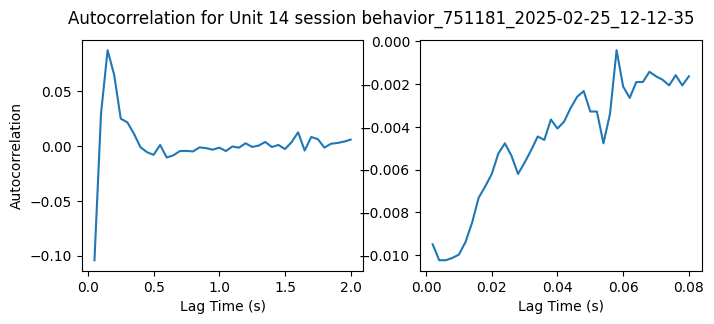

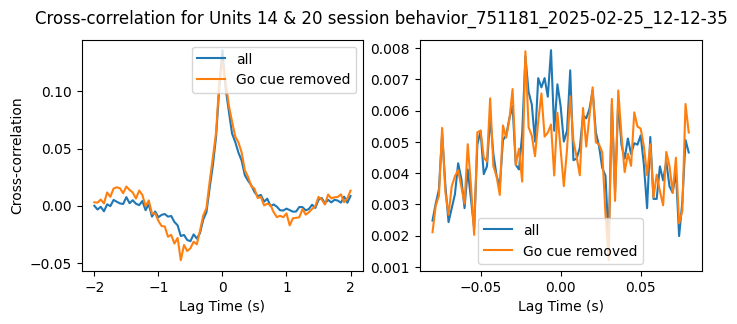

(<Figure size 800x300 with 2 Axes>,
 array([<Axes: xlabel='Lag Time (s)', ylabel='Cross-correlation'>,
        <Axes: xlabel='Lag Time (s)'>], dtype=object))

In [3]:
unit_id = 14
unit_id_pair = (14, 20)
auto_unit = auto_corr.load_unit(unit_id)
auto_corr.plot_unit(unit_id)
pair_cross = cross_corr.load_units(unit_id_pair[0], unit_id_pair[1])
cross_corr.plot_units(unit_id_pair[0], unit_id_pair[1])

# Load data

Applying bounds for isi_violations: [0.0, 0.1]
 - isi_violations: 18300 -> 8322 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8322 -> 5849 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5849 -> 5826 units passed
Applying conditional bounds for y_loc
 - y_loc: 5826 -> 4439 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto units after filtering: 410
Number of non-opto units after filtering: 4439


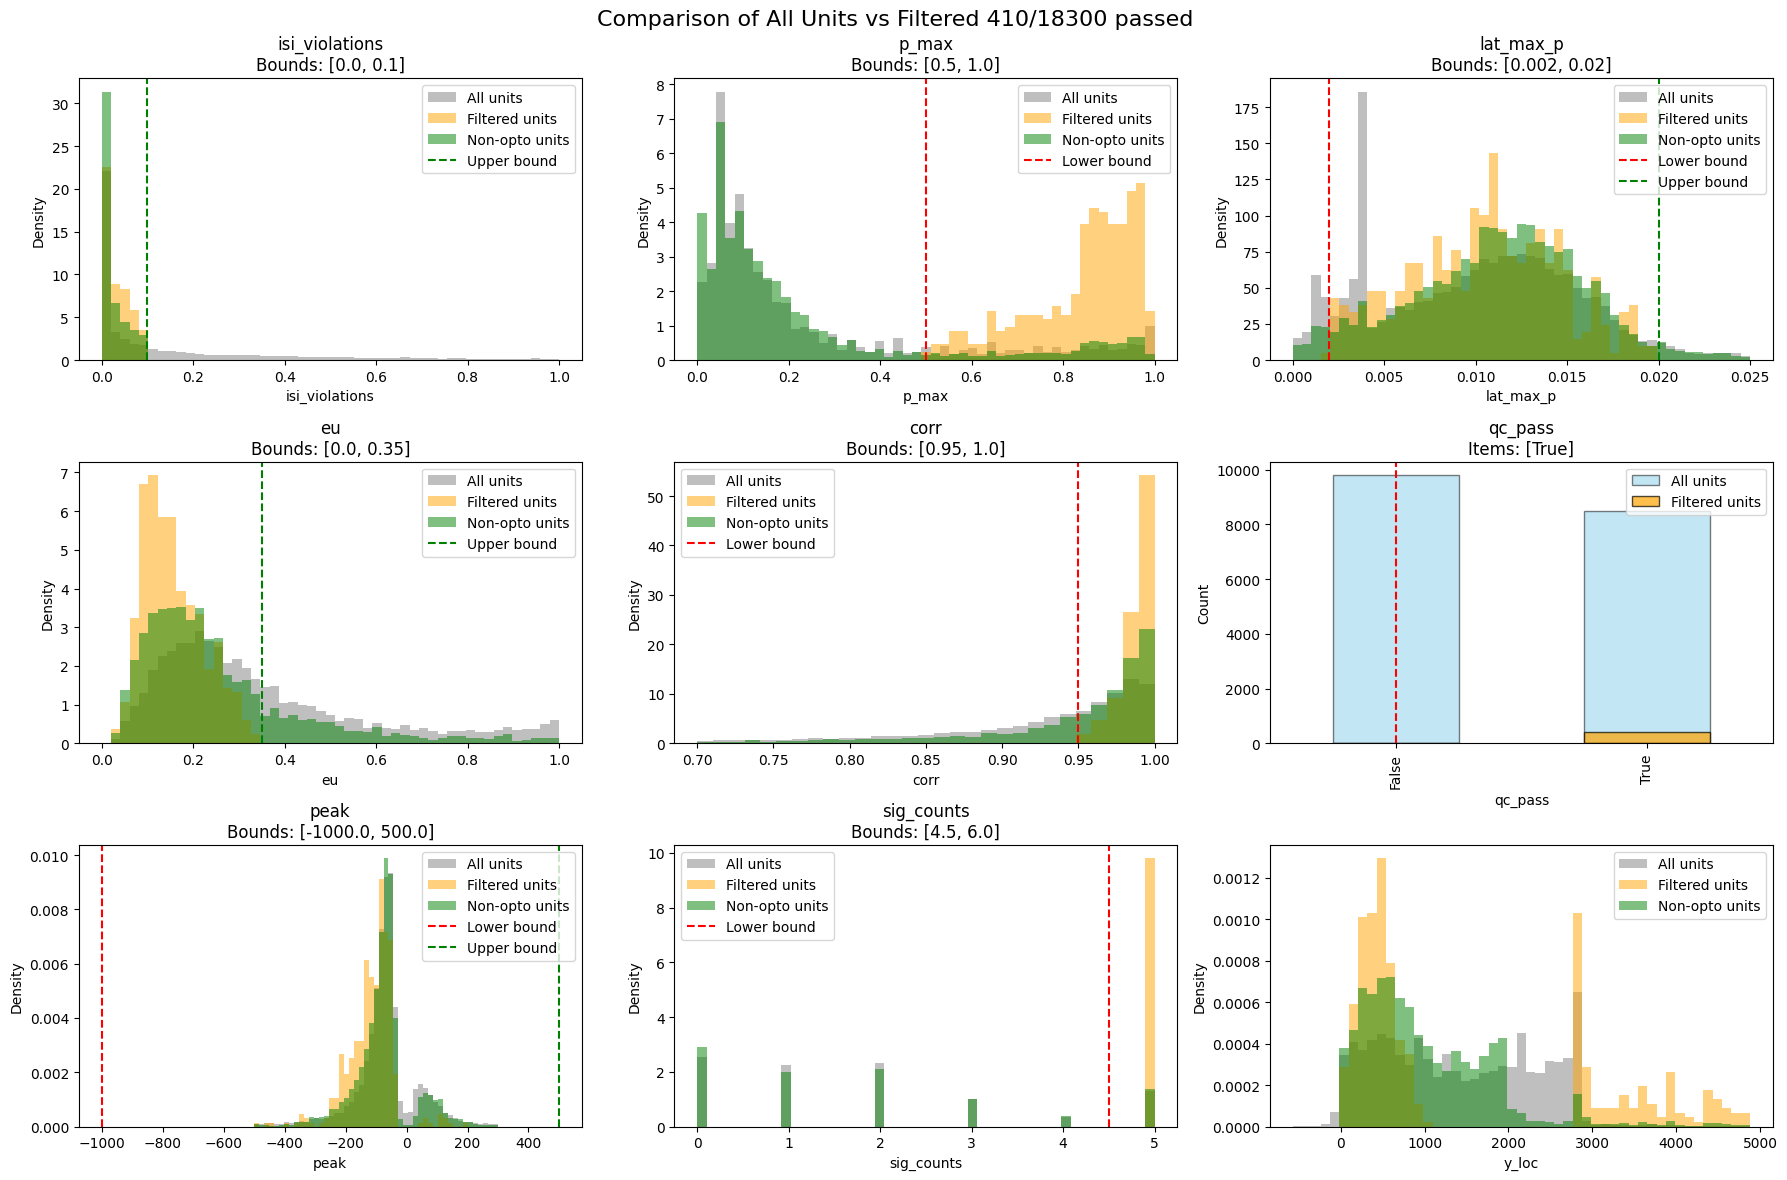

In [4]:
criteria_name = 'basic_ephys'
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)

combined_tagged_units_filtered, combined_tagged_units, fig = apply_qc(combined_tagged_units, constraints)

In [ ]:
# loop through units to load autocorr


In [5]:
# loop through sessions and find a table of session - unit_1 - unit_2 dataframe to load 
session_unit_pairs = []
for session in combined_tagged_units_filtered['session'].unique():
    session_df = combined_tagged_units_filtered[combined_tagged_units_filtered['session'] == session]
    unit_ids = session_df['unit'].to_list()
    for i in range(len(unit_ids)):
        for j in range(i+1, len(unit_ids)):
            session_unit_pairs.append((session, (unit_ids[i], unit_ids[j])))
session_unit_pairs_df = pd.DataFrame(session_unit_pairs, columns=['session', 'unit_pair'])

In [6]:
# load cross-corr for each session - unit pair
cross_corr_list = []
session_list = []
unit_1 = []
unit_2 = []
for idx, row in session_unit_pairs_df.iterrows():
    session = row['session']
    unit_pair = row['unit_pair']
    cross_corr = load_cross_corr(session, data_type)
    if cross_corr is not None:
        pair_cross = cross_corr.load_units(unit_pair[0], unit_pair[1])
        if pair_cross is not None:
            cross_corr_list.append(pair_cross)
            session_list.append(session)
            unit_1.append(unit_pair[0])
            unit_2.append(unit_pair[1])
    else:
        cross_corr_list.append(None)

In [7]:
cross_corr_df = pd.DataFrame(cross_corr_list)
cross_corr_df["session"] = session_list

# find location of each neuron, unit 1 and unit 2, load both ccf locations and y_loc (estimated location along the probe)
cross_corr_df['unit'] = cross_corr_df['unit_1']
cross_corr_df = cross_corr_df.merge(combined_tagged_units_filtered[['session', 'unit', 'y_loc', 'x_ccf', 'y_ccf', 'z_ccf']], on=['session', 'unit'], how='left')
# rename columns to unit 1
cross_corr_df = cross_corr_df.rename(columns={'y_loc': 'y_loc_1', 'x_ccf': 'x_ccf_1', 'y_ccf': 'y_ccf_1', 'z_ccf': 'z_ccf_1'})
cross_corr_df['unit'] = cross_corr_df['unit_2']
cross_corr_df = cross_corr_df.merge(combined_tagged_units_filtered[['session', 'unit', 'y_loc', 'x_ccf', 'y_ccf', 'z_ccf']], on=['session', 'unit'], how='left')
# rename columns to unit 2
cross_corr_df = cross_corr_df.rename(columns={'y_loc': 'y_loc_2', 'x_ccf': 'x_ccf_2', 'y_ccf': 'y_ccf_2', 'z_ccf': 'z_ccf_2'})

In [8]:
print(f'Total unit pairs with cross-corr data: {len(cross_corr_df)}')

Total unit pairs with cross-corr data: 933


# PCA analysis of crosscorr

In [9]:
combined_tagged_units.columns.tolist()

['session',
 'unit',
 'qc_pass',
 'opto_tagged',
 'in_df',
 'trial_count',
 'p_max',
 'p_mean',
 'sig_counts',
 'lat_max_p',
 'isi_violations',
 'snr',
 'eu',
 'corr',
 'amp',
 'amp_raw',
 'peak',
 'peak_raw',
 'wf',
 'wf_raw',
 'wf_aligned',
 'wf_2d',
 'wf_2d_raw',
 'probe',
 'y_loc',
 'rec_side',
 'top',
 'bottom',
 'tag_loc',
 'fr',
 'decoder',
 'all_p_max',
 'all_p_mean',
 'all_lat_max_p',
 'all_corr',
 'all_eu',
 'all_sig_counts',
 'x_ccf',
 'y_ccf',
 'z_ccf',
 'selected_qc_only',
 'count_max',
 'selected_opto_only',
 'selected',
 'selected_no_opto']

Text(0.5, 1.0, 'Short timescale cross-corr (no-go)')

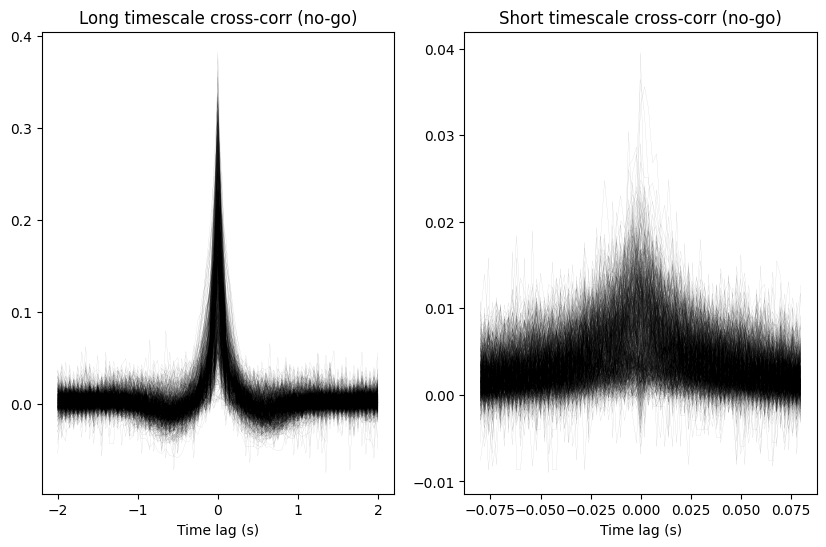

In [10]:
# plot all traces

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
for idx, row in cross_corr_df.iterrows():
    pair_cross = row
    if pair_cross is not None:
        times = pair_cross['long_lags']
        corr_values = pair_cross['cross_corr_long_nogo']
        ax[0].plot(times, corr_values, alpha=0.3, color = 'k', linewidth=0.1)
        times = pair_cross['short_lags']
        corr_values = pair_cross['cross_corr_short_nogo']
        ax[1].plot(times, corr_values, alpha=0.3, color = 'k', linewidth=0.1)
ax[0].set_xlabel('Time lag (s)')
ax[0].set_title('Long timescale cross-corr (no-go)')
ax[1].set_xlabel('Time lag (s)')
ax[1].set_title('Short timescale cross-corr (no-go)')

In [11]:
all_long_corr.shape[1]

NameError: name 'all_long_corr' is not defined

Text(0.5, 1.0, 'Short timescale cross-corr center bin (no-go)')

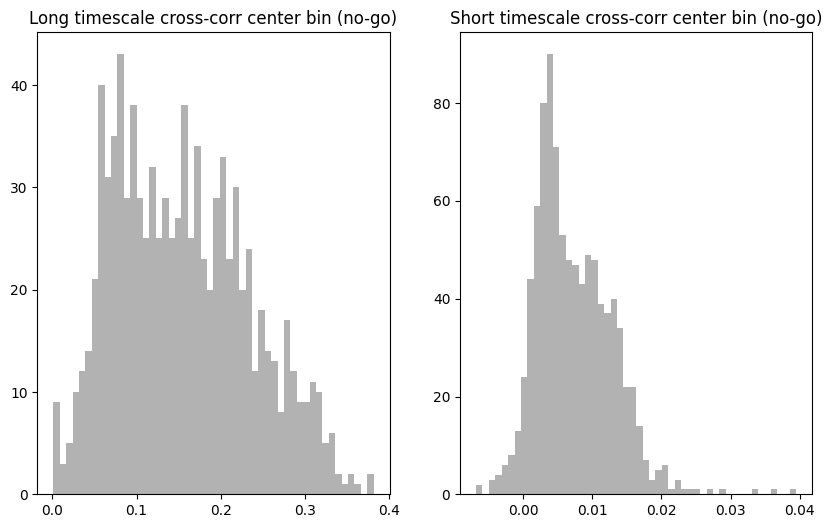

In [ ]:
all_long_corr = np.array(cross_corr_df['cross_corr_long_nogo'].to_list())
all_short_corr = np.array(cross_corr_df['cross_corr_short_nogo'].to_list())
center_long = all_long_corr[:, all_long_corr.shape[1] // 2]
center_short = all_short_corr[:, all_short_corr.shape[1] // 2]

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].hist(center_long, bins=50, alpha=0.3, color='k');
ax[1].hist(center_short, bins=50, alpha=0.3, color='k');
ax[0].set_title('Long timescale cross-corr center bin (no-go)')
ax[1].set_title('Short timescale cross-corr center bin (no-go)')

In [ ]:
# zscore
from scipy.stats import zscore
balanced_long_corr = all_long_corr - np.mean(all_long_corr, axis=0, keepdims=True)
balanced_long_corr = zscore(balanced_long_corr, axis=0)
# balanced_long_corr = zscore(balanced_long_corr, axis=0)
balanced_long_corr = np.concat([balanced_long_corr, np.flip(balanced_long_corr, 1)], axis=0)
all_long_corr_for_plot = np.concat([all_long_corr, np.flip(all_long_corr, 1)], axis=0)

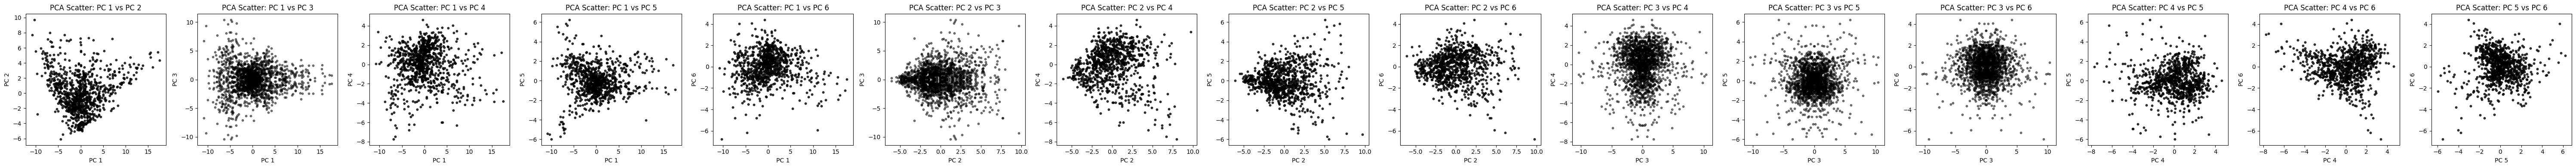

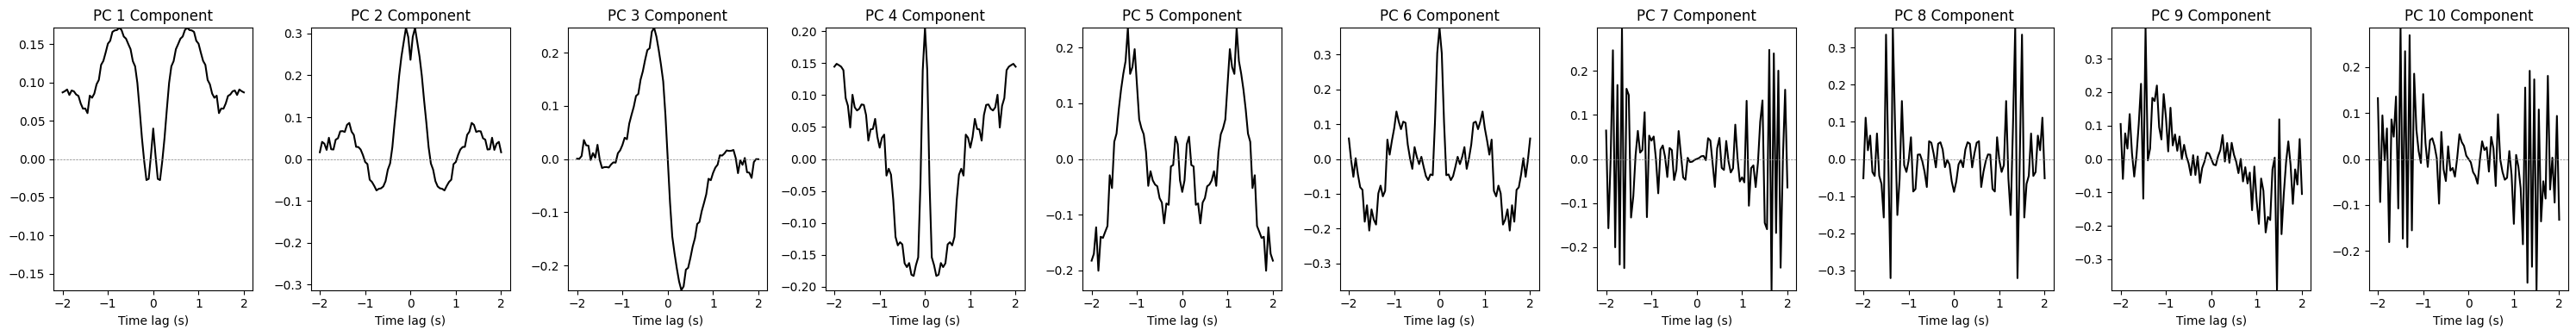

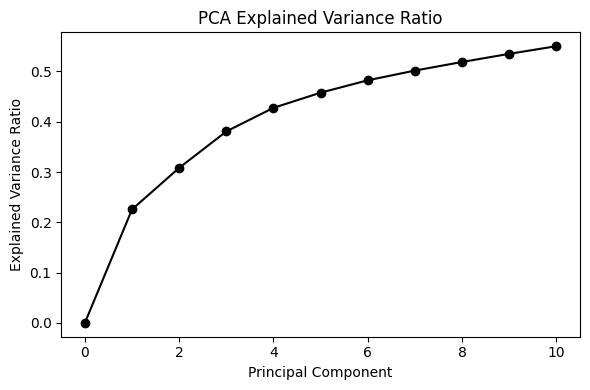

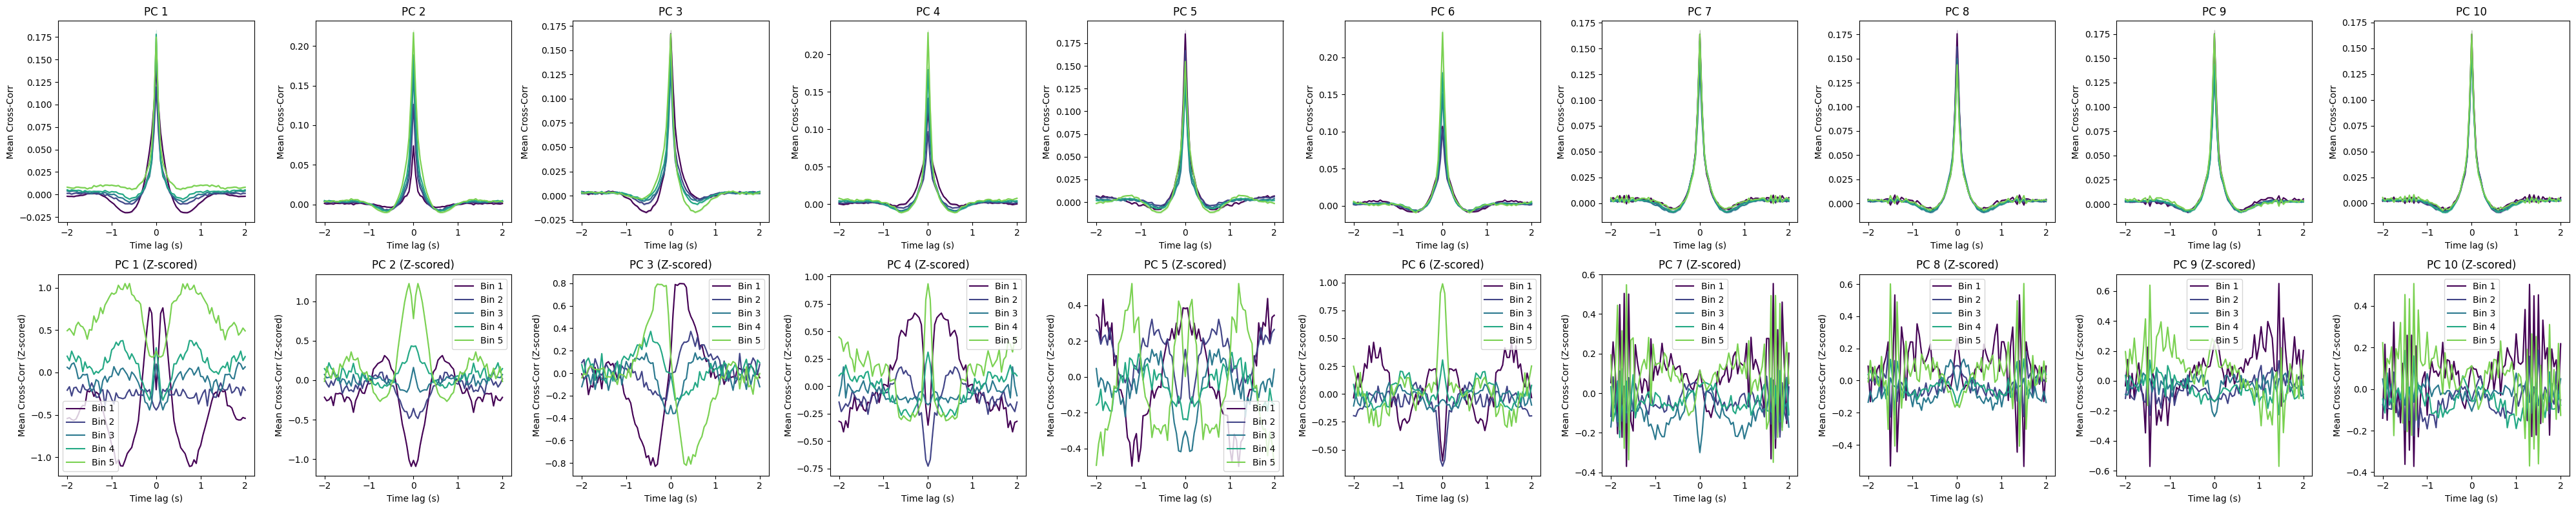

In [ ]:
# pca on long timescale cross-corr
from sklearn.decomposition import PCA
num_components = 10
pca = PCA(n_components=num_components)
pca.fit(balanced_long_corr)
long_corr_pca = pca.transform(balanced_long_corr)
import itertools
import matplotlib.pyplot as plt

def plot_pca_pairs(pca_data, max_components=None, figsize=(12, 4)):
    """
    pca_data: array (n_samples × n_components)
    max_components: number of components to visualize (default = all)
    """

    # Determine how many components to use
    n_components = pca_data.shape[1]
    if max_components is not None:
        n_components = min(max_components, n_components)

    component_indices = range(n_components)

    # Generate all unique pairs: (0,1), (0,2), (1,2), ...
    pairs = list(itertools.combinations(component_indices, 2))

    # Determine layout
    n_plots = len(pairs)
    fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 4), squeeze=False)
    axes = axes.ravel()

    # Plot each pair
    for ax, (i, j) in zip(axes, pairs):
        ax.scatter(pca_data[:, i], pca_data[:, j], alpha=0.5, color='k', s=10)
        ax.set_xlabel(f"PC {i+1}")
        ax.set_ylabel(f"PC {j+1}")
        ax.set_title(f"PCA Scatter: PC {i+1} vs PC {j+1}")

    plt.tight_layout()
    return fig, axes

fig, axes = plot_pca_pairs(long_corr_pca, max_components=6)

# plot component of each PC
fig, ax = plt.subplots(1, num_components, figsize=(3*num_components, 4))
lags = cross_corr_df.iloc[0]['long_lags']
for i in range(num_components):
    ax[i].plot(lags, pca.components_[i], color='k')
    ax[i].set_title(f'PC {i+1} Component')
    ax[i].set_xlabel('Time lag (s)')
    amp = np.max(np.abs(pca.components_[i]))
    ax[i].set_ylim([-amp, amp])
    ax[i].axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()

# plot explained variance
explained_variance = pca.explained_variance_ratio_
explained_variance = np.cumsum(explained_variance)
explained_variance = np.insert(explained_variance, 0, 0)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(range(len(explained_variance)), explained_variance, marker='o', color='k')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('PCA Explained Variance Ratio')
plt.tight_layout()


# plot mean of cross correltions binned by score of each pc
num_bins = 5
fig, axes = plt.subplots(2, num_components, figsize=(4*num_components, 8))
for pc_idx in range(num_components):
    pc_scores = long_corr_pca[:, pc_idx]
    bin_edges = np.percentile(pc_scores, np.linspace(0, 100, num_bins + 1))
    binned_means = []
    binned_means_ori = []
    binned_sems = []
    binned_sems_ori = []
    for i in range(num_bins):
        bin_mask = (pc_scores >= bin_edges[i]) & (pc_scores < bin_edges[i + 1])
        bin_data = all_long_corr_for_plot[bin_mask]
        bin_data_ori = balanced_long_corr[bin_mask]
        mean_corr = np.mean(bin_data, axis=0)
        mean_corr_ori = np.mean(bin_data_ori, axis=0)
        sem_corr = np.std(bin_data, axis=0) / np.sqrt(bin_data.shape[0])
        sem_corr_ori = np.std(bin_data_ori, axis=0) / np.sqrt(bin_data_ori.shape[0])
        binned_means.append(mean_corr)
        binned_means_ori.append(mean_corr_ori)
        binned_sems.append(sem_corr)
        binned_sems_ori.append(sem_corr)
    
    # Plotting
    ax = axes[0, pc_idx]
    lags = cross_corr_df.iloc[0]['long_lags']
    for i in range(num_bins):
        ax.plot(lags, binned_means[i], label=f'Bin {i+1}', color=plt.cm.viridis(i / num_bins))
        ax.fill_between(lags, 
                        binned_means[i] - binned_sems[i], 
                        binned_means[i] + binned_sems[i], 
                        alpha=0.2, 
                        color=plt.cm.viridis(i / num_bins)
        )
    ax.set_title(f'PC {pc_idx+1}')
    ax.set_xlabel('Time lag (s)')
    ax.set_ylabel('Mean Cross-Corr')
    ax = axes[1, pc_idx]
    for i in range(num_bins):
        ax.plot(lags, binned_means_ori[i], label=f'Bin {i+1}', color=plt.cm.viridis(i / num_bins))
        ax.fill_between(lags, 
                        binned_means_ori[i] - binned_sems_ori[i], 
                        binned_means_ori[i] + binned_sems_ori[i], 
                        alpha=0.2, 
                        color=plt.cm.viridis(i / num_bins)
        )
    ax.set_title(f'PC {pc_idx+1} (Z-scored)')
    ax.set_xlabel('Time lag (s)')
    ax.set_ylabel('Mean Cross-Corr (Z-scored)')

    ax.legend()
    plt.tight_layout()

In [ ]:
combined_tagged_units[]

In [77]:
# flip units based on sign of PC2
cross_corr_df_flipped = cross_corr_df.copy()
scores_pc2 = pca.transform(balanced_long_corr[:len(all_long_corr), :])[ :, 1]
flip_indices = scores_pc2 < 0
cross_corr_df_flipped.loc[flip_indices, 'unit_1'], cross_corr_df_flipped.loc[flip_indices, 'unit_2'] = \
    cross_corr_df_flipped.loc[flip_indices, 'unit_2'], cross_corr_df_flipped.loc[flip_indices, 'unit_1'].values
cross_corr_df_flipped.loc[flip_indices, 'y_loc_1'], cross_corr_df_flipped.loc[flip_indices, 'y_loc_2'] = \
    cross_corr_df_flipped.loc[flip_indices, 'y_loc_2'], cross_corr_df_flipped.loc[flip_indices, 'y_loc_1'].values
cross_corr_df_flipped.loc[flip_indices, 'x_ccf_1'], cross_corr_df_flipped.loc[flip_indices, 'x_ccf_2'] = \
    cross_corr_df_flipped.loc[flip_indices, 'x_ccf_2'], cross_corr_df_flipped.loc[flip_indices, 'x_ccf_1'].values
cross_corr_df_flipped.loc[flip_indices, 'y_ccf_1'], cross_corr_df_flipped.loc[flip_indices, 'y_ccf_2'] = \
    cross_corr_df_flipped.loc[flip_indices, 'y_ccf_2'], cross_corr_df_flipped.loc[flip_indices, 'y_ccf_1'].values
cross_corr_df_flipped.loc[flip_indices, 'z_ccf_1'], cross_corr_df_flipped.loc[flip_indices, 'z_ccf_2'] = \
    cross_corr_df_flipped.loc[flip_indices, 'z_ccf_2'], cross_corr_df_flipped.loc[flip_indices, 'z_ccf_1'].values
cross_corr_df_flipped.loc[flip_indices, 'cross_corr_long_nogo'] = \
    cross_corr_df_flipped.loc[flip_indices, 'cross_corr_long_nogo'].apply(lambda x: np.flip(x))
cross_corr_df_flipped.loc[flip_indices, 'cross_corr_short_nogo'] = \
    cross_corr_df_flipped.loc[flip_indices, 'cross_corr_short_nogo'].apply(lambda x: np.flip(x))

In [79]:
# redo PCA with flipped data
from scipy.stats import zscore
flipped_long_corr = np.array(cross_corr_df_flipped['cross_corr_long_nogo'].to_list())
flipped_long_corr = zscore(flipped_long_corr, axis=0)

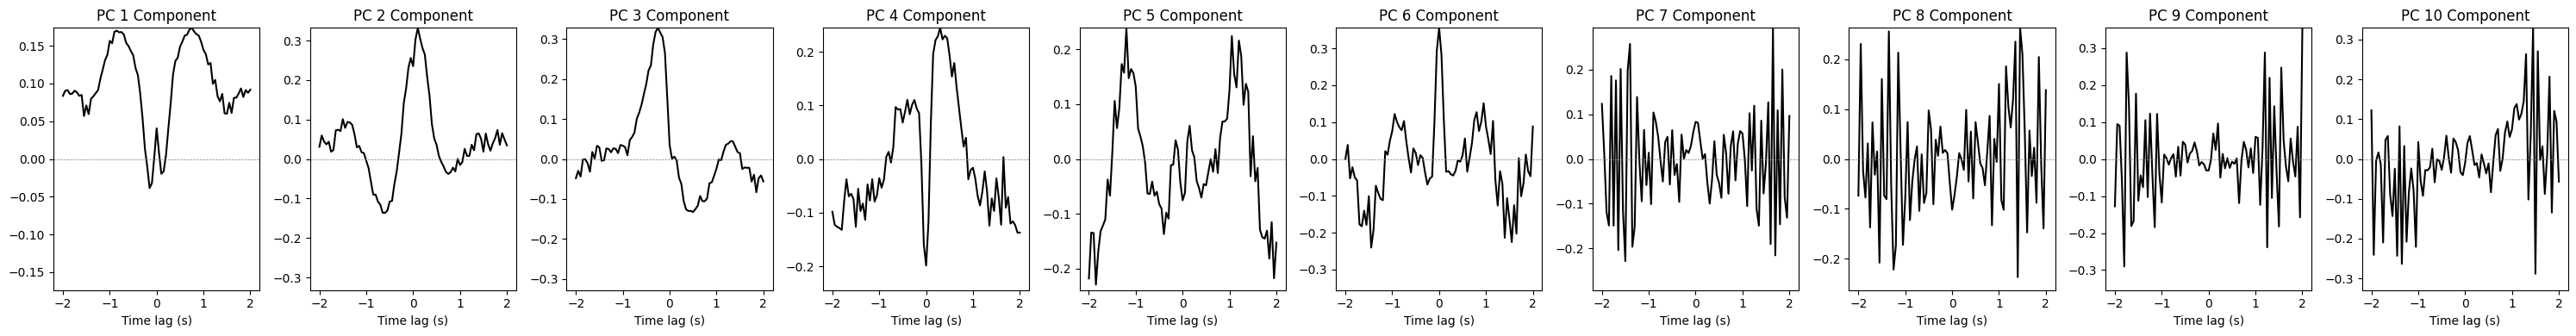

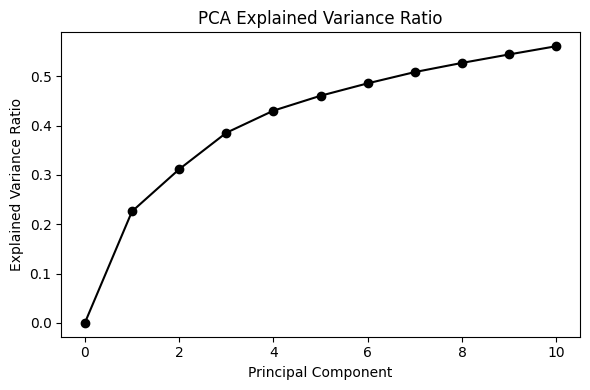

In [80]:
# pca on long timescale cross-corr
from sklearn.decomposition import PCA
num_components = 10
pca = PCA(n_components=num_components)
pca.fit(flipped_long_corr)
long_corr_pca = pca.transform(flipped_long_corr)
import itertools
import matplotlib.pyplot as plt

# plot component of each PC
fig, ax = plt.subplots(1, num_components, figsize=(3*num_components, 4))
lags = cross_corr_df.iloc[0]['long_lags']
for i in range(num_components):
    ax[i].plot(lags, pca.components_[i], color='k')
    ax[i].set_title(f'PC {i+1} Component')
    ax[i].set_xlabel('Time lag (s)')
    amp = np.max(np.abs(pca.components_[i]))
    ax[i].set_ylim([-amp, amp])
    ax[i].axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()

# plot explained variance
explained_variance = pca.explained_variance_ratio_
explained_variance = np.cumsum(explained_variance)
explained_variance = np.insert(explained_variance, 0, 0)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(range(len(explained_variance)), explained_variance, marker='o', color='k')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('PCA Explained Variance Ratio')
plt.tight_layout()